In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Jednostki atomowe
hbar = 1           # jednostka działania
m = 0.067          # efektywna masa elektronu w GaAs
L_nm = 100         # długość studni w nm
L = L_nm / 0.05292 # długość w jednostkach atomowych
N = 100            # liczba punktów siatki``
dx = L / N         # krok siatki
x = np.linspace(0, L, N+1)  # siatka przestrzenna

# Potencjał V(x) = 0
V = np.zeros(N+1)

# Przeliczenie jednostek energii
meV_to_au = 1 / 27211.6
au_to_meV = 27211.6


1. a)

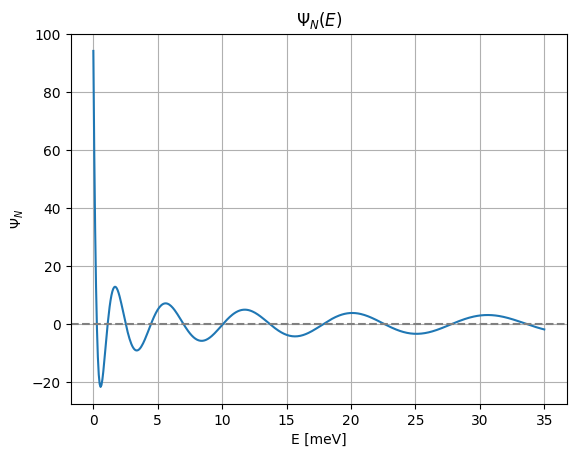

In [211]:
def solve_wavefunction(E_meV, V):
    E = E_meV * meV_to_au
    psi = np.zeros(N+1)
    psi[0] = 0
    psi[1] = 1
    for i in range(1, N):
        psi[i+1] = (2 * psi[i] * (1 - (2 * m * dx**2 / hbar**2) * (E - V[i])) - psi[i-1])
    return psi

E_vals = np.linspace(0.01, 35, 500)
psi_N_vals = [solve_wavefunction(E, V)[-1] for E in E_vals]

plt.plot(E_vals, psi_N_vals)
plt.axhline(0, color='gray', linestyle='--')
plt.xlabel("E [meV]")

plt.ylabel(r"$\Psi_N$")  
plt.title(r"$\Psi_N (E)$")
plt.grid(True)
plt.show()

1. b)

In [212]:
def find_all_zeros(E_grid_meV, V):
    psiN_vals = [solve_wavefunction(E, V)[-1] for E in E_grid_meV]
    signs = np.sign(psiN_vals)
    change_idx = np.where(np.diff(signs) != 0)[0]

    zeros_meV = []
    for i in change_idx:
        x1 = E_grid_meV[i]; x2 = E_grid_meV[i+1]
        y1 = psiN_vals[i]; y2 = psiN_vals[i+1]
        # interpolacja liniowa
        root = x1 - y1 * (x2 - x1) / (y2 - y1)
        zeros_meV.append(root)

    return zeros_meV


In [213]:
E_grid_meV = np.linspace(0.01, 35, 1000)
zeros_meV = find_all_zeros(E_grid_meV, V)

print(f"Znaleziono przybliżone miejsca zerowe (liczba): {len(zeros_meV)}")
if len(zeros_meV) > 0:
    for j, z in enumerate(zeros_meV):
        print(f"  zero {j+1}: E ≈ {z:.6f} meV")
else:
    raise SystemExit("Brak wykrytych zmian znaku w przedziale energii.")

# Wybór pierwszego miejsca zerowego
E_zero = zeros_meV[1]
print(f"Wybrano drugie miejsce zerowe: E0 = {E_zero:.6f} meV")


Znaleziono przybliżone miejsca zerowe (liczba): 11
  zero 1: E ≈ 0.281257 meV
  zero 2: E ≈ 1.122361 meV
  zero 3: E ≈ 2.524005 meV
  zero 4: E ≈ 4.484466 meV
  zero 5: E ≈ 7.001763 meV
  zero 6: E ≈ 10.073393 meV
  zero 7: E ≈ 13.696330 meV
  zero 8: E ≈ 17.866998 meV
  zero 9: E ≈ 22.581288 meV
  zero 10: E ≈ 27.834534 meV
  zero 11: E ≈ 33.621556 meV
Wybrano drugie miejsce zerowe: E0 = 1.122361 meV


In [214]:
def normalize(psi):
    C = dx * np.sum(psi**2)
    return psi / np.sqrt(C)


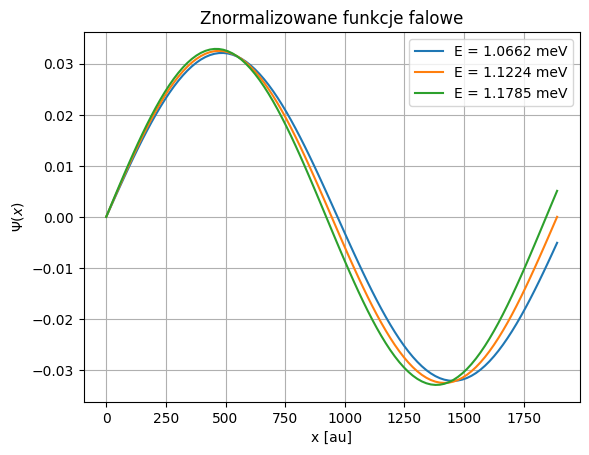

In [215]:
E_vals = [E_zero * 0.95, E_zero, E_zero * 1.05]

for E in E_vals:
    psi = normalize(solve_wavefunction(E, V))
    plt.plot(x, psi, label=f"E = {E:.4f} meV")

plt.xlabel("x [au]")
plt.ylabel(r"$ \Psi (x)$")
plt.title("Znormalizowane funkcje falowe")
plt.legend()
plt.grid(True)
plt.show()


2. a)

In [216]:
def solve_wavefunction(E_meV, N, V=None):
    E_au = E_meV * meV_to_au
    dx = L / N
    psi = np.zeros(N+1)
    psi[0] = 0.0
    psi[1] = 1.0
    pref = 2.0 * m * dx**2 / hbar**2
    if V is None:
        V = np.zeros(N+1)
    for i in range(1, N):
        psi[i+1] = 2*psi[i] - psi[i-1] - pref * (E_au - V[i]) * psi[i]
    return psi[-1]

In [217]:
def find_zero(E1_meV, E2_meV, N, V=None, tol_meV=1e-6, max_iter=100):
    f1 = solve_wavefunction(E1_meV, N, V)
    f2 = solve_wavefunction(E2_meV, N, V)
    if f1 * f2 > 0:
        return None
    for _ in range(max_iter):
        Em = 0.5 * (E1_meV + E2_meV)
        fm = solve_wavefunction(Em, N, V)
        if abs(E2_meV - E1_meV) < tol_meV:
            return Em
        if f1 * fm <= 0:
            E2_meV, f2 = Em, fm
        else:
            E1_meV, f1 = Em, fm
    return 0.5 * (E1_meV + E2_meV)

In [218]:
def find_all_zeros(N, V=None, E_min=0.0, E_max=35.0, nE=2000):
    E_grid = np.linspace(E_min, E_max, nE)
    psiN_vals = np.array([solve_wavefunction(E, N, V) for E in E_grid])
    signs = np.sign(psiN_vals)
    change_idx = np.where(np.diff(signs) != 0)[0]
    zeros = []
    for i in change_idx:
        root = find_zero(E_grid[i], E_grid[i+1], N, V)
        if root is not None:
            zeros.append(root)
    return zeros

In [219]:
def analytical_energy(n, L=L, m=m):
    E_au = (n**2 * np.pi**2 * hbar**2) / (2.0 * m * L**2)
    return E_au * au_to_meV

In [220]:
def analytical_levels(n_levels=5):
    return [analytical_energy(n) for n in range(1, n_levels+1)]

In [221]:
for N in [100, 300]:
    print(f"Wyniki dla N = {N}")
    roots = find_all_zeros(N)
    ana = analytical_levels(len(roots))
    print(f"Znaleziono {len(roots)} energii własnych.")
    print(f"{'i':>3} | {'E_num [meV]':>15} | {'E_exact [meV]':>15} | {'|diff| [meV]':>15}")
    print("-"*55)
    for i, (En, Ea) in enumerate(zip(roots, ana), 1):
        diff = abs(En - Ea)
        print(f"{i:3d} | {En:15.6f} | {Ea:15.6f} | {diff:15.6f}")

Wyniki dla N = 100
Znaleziono 7 energii własnych.
  i |     E_num [meV] |   E_exact [meV] |    |diff| [meV]
-------------------------------------------------------
  1 |        0.561245 |        0.561292 |        0.000046
  2 |        2.244429 |        2.245167 |        0.000738
  3 |        5.047888 |        5.051626 |        0.003738
  4 |        8.968857 |        8.980669 |        0.011812
  5 |       14.003466 |       14.032295 |        0.028829
  6 |       20.146747 |       20.206505 |        0.059758
  7 |       27.392636 |       27.503298 |        0.110662
Wyniki dla N = 300
Znaleziono 7 energii własnych.
  i |     E_num [meV] |   E_exact [meV] |    |diff| [meV]
-------------------------------------------------------
  1 |        0.561287 |        0.561292 |        0.000005
  2 |        2.245085 |        2.245167 |        0.000082
  3 |        5.051211 |        5.051626 |        0.000415
  4 |        8.979356 |        8.980669 |        0.001313
  5 |       14.029090 |       14.0

3. a)

In [222]:
def central_barrier_potential(N, W_eV):
    V = np.zeros(N+1)
    V[N//2] = -W_eV * 1000 * meV_to_au  # W [eV] → meV → au
    return V


In [223]:
def energy_levels_vs_W(N=300, W_values=np.linspace(0, 1, 50), n_levels=7):
    energy_matrix = []

    for W in W_values:
        V = central_barrier_potential(N, W)
        roots = find_all_zeros(N, V=V, E_min=-100, E_max=50, nE=3000)
        energy_matrix.append(roots[:n_levels])  # tylko najniższe poziomy

    energy_matrix = np.array(energy_matrix)

    plt.figure(figsize=(10, 6))
    for i in range(n_levels):
        plt.plot(W_values, energy_matrix[:, i], label=f"Stan {i+1}")
    plt.xlabel("W [eV]")
    plt.ylabel("Energia [meV]")
    plt.title("7 najniższych poziomów energetycznych vs W")
    plt.legend()
    plt.grid(True)
    plt.show()

    return energy_matrix, W_values


In [224]:
def plot_wavefunctions_for_W(N=300, W_eV=0.5, n_states=4):
    V = central_barrier_potential(N, W_eV)
    roots = find_all_zeros(N, V=V, E_min=-100, E_max=50, nE=3000)
    x = np.linspace(0, L, N+1)

    plt.figure(figsize=(10, 6))
    for i in range(n_states):
        E = roots[i]
        psi = np.zeros(N+1)
        psi[0] = 0.0
        psi[1] = 1.0
        dx = L / N
        pref = 2.0 * m * dx**2 / hbar**2
        for j in range(1, N):
            psi[j+1] = 2*psi[j] - psi[j-1] - pref * (E * meV_to_au - V[j]) * psi[j]
        # normalizacja
        C = dx * np.sum(psi**2)
        psi /= np.sqrt(C)
        plt.plot(x, psi, label=f"Stan {i+1}, E={E:.2f} meV")

    plt.xlabel("x [au]")
    plt.ylabel("Ψ(x)")
    plt.title(f"Funkcje falowe dla W = {W_eV} eV")
    plt.legend()
    plt.grid(True)
    plt.show()


In [225]:
def compare_wavefunctions_vs_W(N=300, W_list=[0.0, 0.5, 1.0], states=[0, 1]):
    x = np.linspace(0, L, N+1)
    plt.figure(figsize=(12, 6))

    for state in states:
        plt.subplot(1, 2, state+1)
        for W in W_list:
            V = central_barrier_potential(N, W)
            roots = find_all_zeros(N, V=V, E_min=-100, E_max=50, nE=3000)
            E = roots[state]
            psi = np.zeros(N+1)
            psi[0] = 0.0
            psi[1] = 1.0
            dx = L / N
            pref = 2.0 * m * dx**2 / hbar**2
            for j in range(1, N):
                psi[j+1] = 2*psi[j] - psi[j-1] - pref * (E * meV_to_au - V[j]) * psi[j]
            C = dx * np.sum(psi**2)
            psi /= np.sqrt(C)
            plt.plot(x, psi, label=f"W={W} eV, E={E:.2f} meV")
        plt.title(f"Stan {state+1}")
        plt.xlabel("x [au]")
        plt.ylabel("Ψ(x)")
        plt.legend()
        plt.grid(True)

    plt.suptitle("Zmiany funkcji falowej dla różnych W")
    plt.tight_layout()
    plt.show()



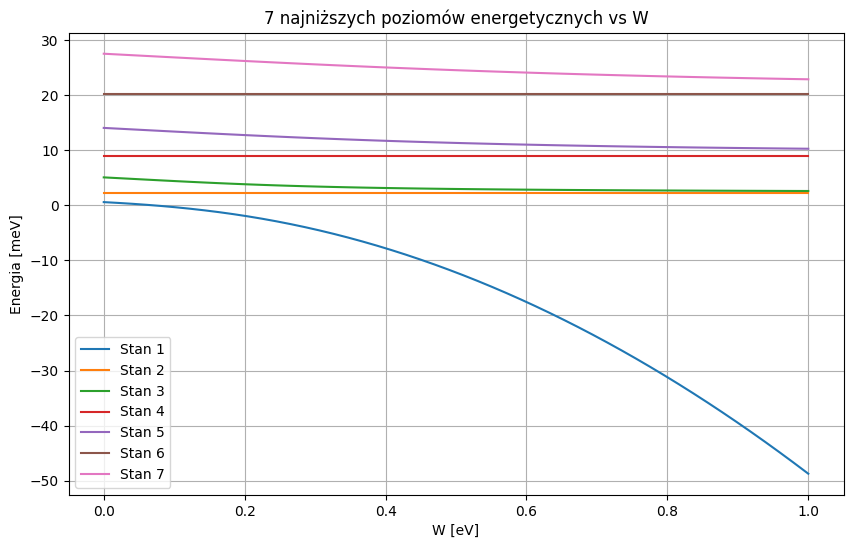

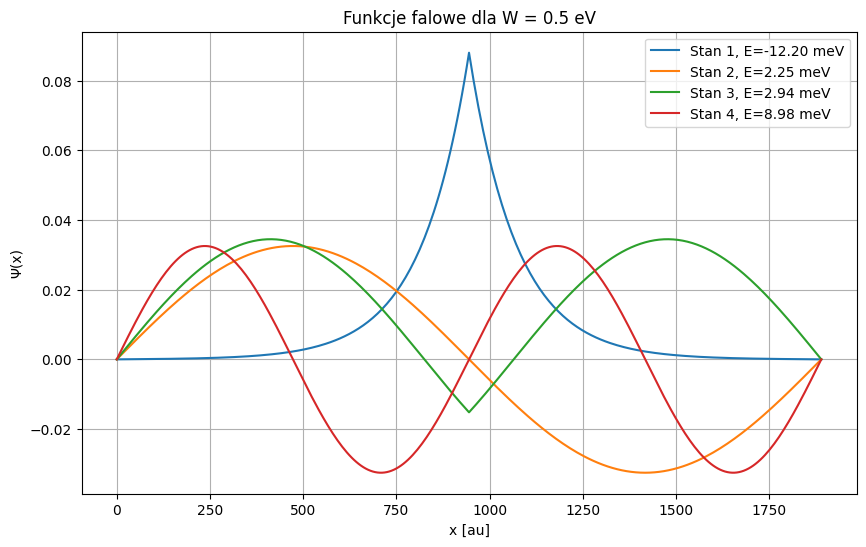

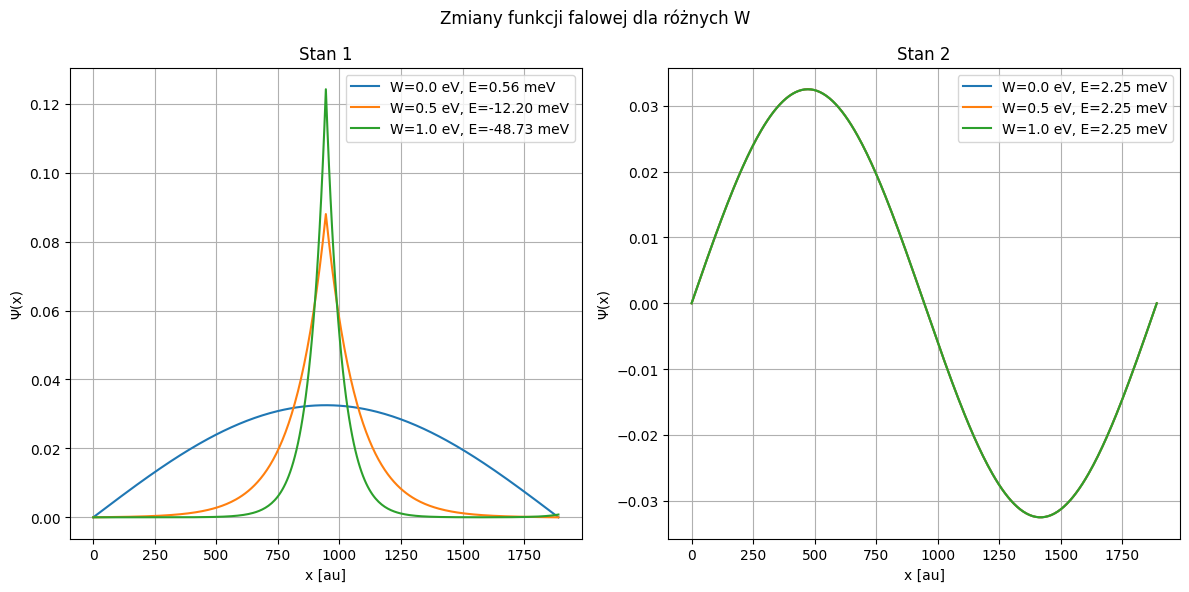

In [226]:
energy_levels_vs_W()
plot_wavefunctions_for_W()
compare_wavefunctions_vs_W()
